<a href="https://colab.research.google.com/github/briangasca/Models/blob/main/ARIMA_REGRESSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

<ipython-input-3-3c4374f6c60d>:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


[*********************100%%**********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2018-09-07  17.340000  17.889999  16.816668  17.549334  17.549334  337378500
2018-09-10  18.217333  19.068666  18.066668  19.033333  19.033333  214252500
2018-09-11  18.631332  18.799999  18.236668  18.629333  18.629333  137550000
2018-09-12  18.762667  19.500000  18.576668  19.369333  19.369333  150231000
2018-09-13  19.201332  19.666668  19.011999  19.297333  19.297333   95104500
(1257, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


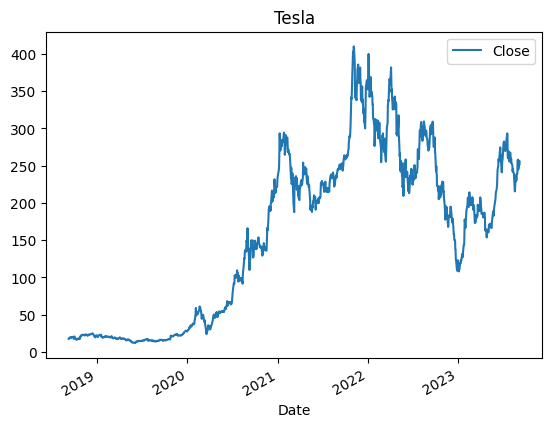

Text(0.5, 1.0, 'Tesla Autocorrelation plot')

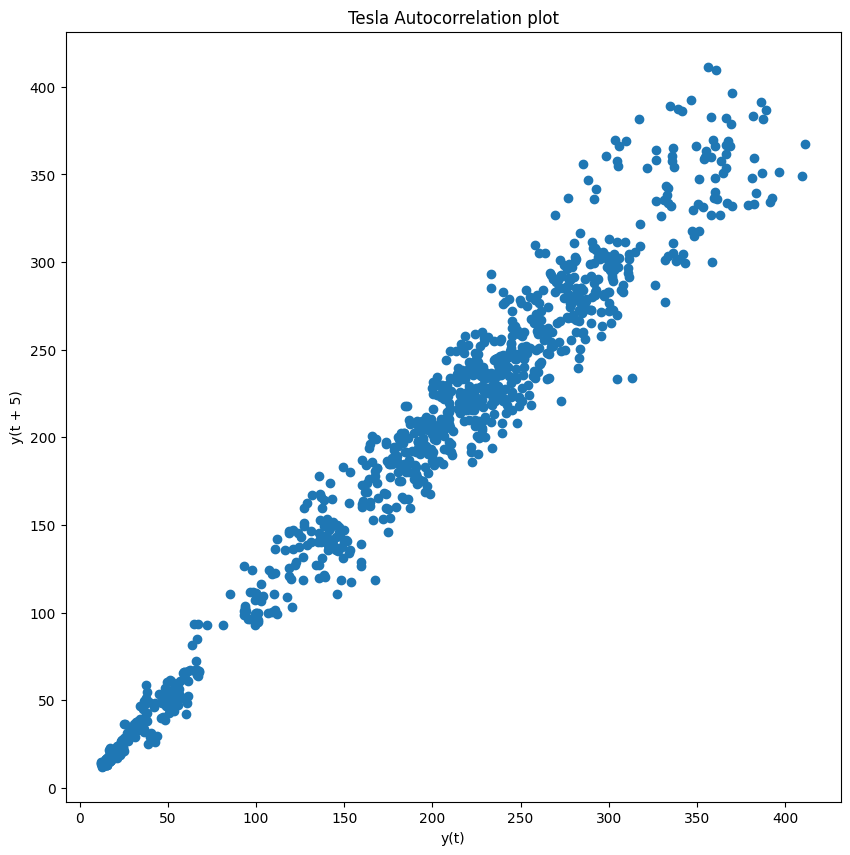

In [ ]:
df = yf.download(tickers=['TSLA'], period='5y')


print(df.head())
print(df.shape)
print(df.columns)

#OVERALL STOCK VAL!!
df[['Close']].plot()
plt.title('Tesla')
plt.show()

plt.figure(figsize=(10,10))
lag_plot(df['Open'], lag=5)
plt.title('Tesla Autocorrelation plot')
#LINEAR LAG PLOT MEANS ITS AUTOREGRESSIVE!!


(1257, 6)
(1005, 6)


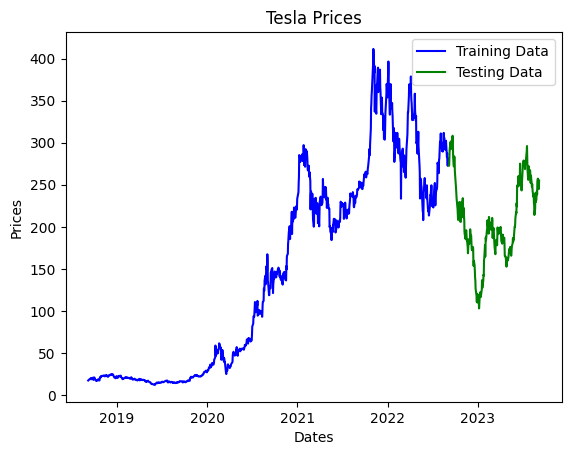

In [ ]:
#Train Data is 90% of the array.
train_data = df[0:int(len(df)*0.8)]
print(df.shape)
#Test_data is the last 10% of the array, ':' slices the first 80%.
#The Machine has never seen this data yet, so it's good to train it on.
test_data = df[int(len(df) * 0.8):]

#Plotting
#Labeling
plt.title('Tesla Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
#Graph, Blue is "Training data" and Green is "Test data"
plt.plot(train_data['Open'], 'blue', label="Training Data")
plt.plot(test_data['Open'], 'green', label='Testing Data')

#X-axis ticks, df.shape is 2956 elements per column, every 600 elements pick a date and label it on the x-axis from 0 up until 2956.
print(train_data.shape)
plt.legend()


#Symmetric Mean Absolute Percentage Error (SMAPE) We will use SMAPE to determine later how good our predictions are.
# Lower means more accurate. We want to be within 5% and 20%
def smape(y_true, y_prediction):
    # average of |Prediction Value - Actual Value| / (|Actual Value| + |Prediction Value|) / 2
    return np.mean((np.abs(y_prediction - y_true) * 200/ (np.abs(y_prediction) + np.abs(y_true))))

Symmetric mean absolute percentage error: 3.308
[281.28972384447763, 273.0362422970765, 272.9792455452503, 281.32507477492896, 290.49133893483565, 300.142662354193, 293.2418971798643, 292.14537270245506, 301.33279833446875, 299.26257349060404, 300.0666531556723, 306.7421257360574, 307.8209016161562, 300.3177983830475, 284.3266379170737, 272.67501648700744, 283.4478874887115, 283.10343378196075, 282.70271708414094, 267.7070022816176, 255.13060036146126, 251.31929067155053, 245.27979196930795, 239.9426210315427, 234.52577494887583, 224.54949145876554, 221.24001280205798, 215.7902015266509, 208.55874875100426, 223.42347656792552, 210.77186201546064, 227.92247180852178, 221.21707310865258, 208.12014595258537, 207.39163519367648, 205.64672901427002, 209.74911665313851, 218.948968064041, 229.0550332326369, 225.50550360338835, 226.03598385991995, 233.74770644234385, 226.23579790679565, 212.19450271254283, 222.31455053001184, 209.45938146469376, 194.68857448663772, 191.78959632981426, 189.6700

<ipython-input-12-51ece56debba>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "green" (-> color=(0.0, 0.5019607843137255, 0.0, 1.0)). The keyword argument will take precedence.
  plt.plot(df['Open'], 'green', color='blue', label='Training Data')


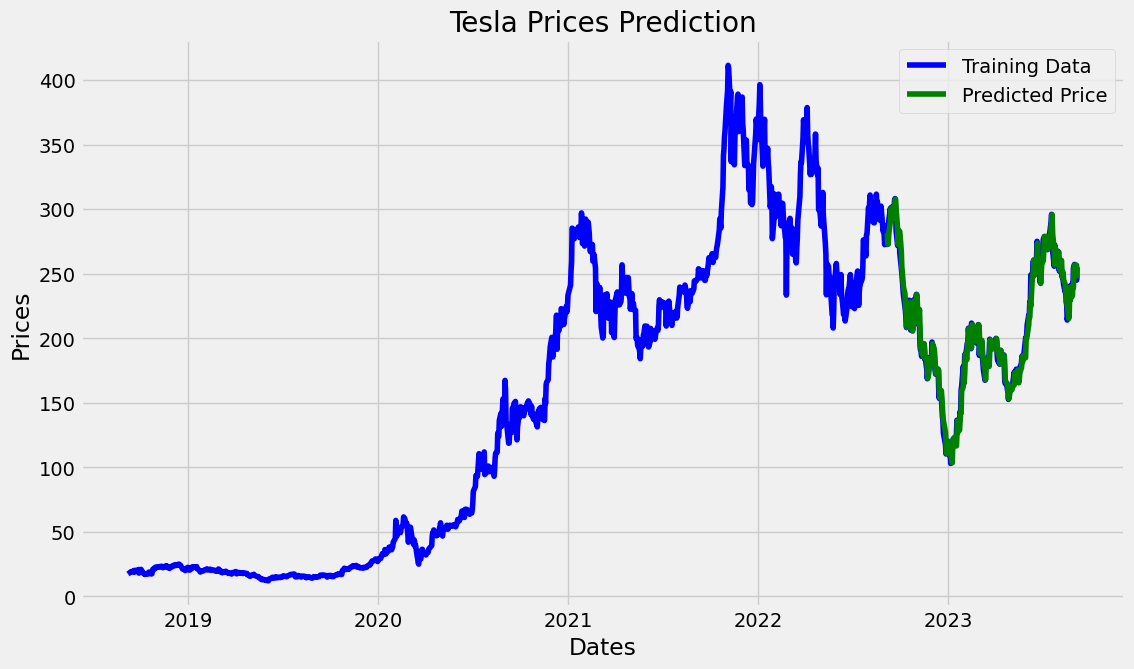

In [ ]:
#Gets values of training data and testing data in a single array.
train_arr = train_data['Open'].values
test_arr = test_data['Open'].values

history = [x for x in train_arr]
predictions = []

for t in range(len(test_arr)):
  model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  predictions.append(output[0])
  obs = test_arr[t]
  history.append(obs)
error2 = smape(test_arr, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)
rms = mean_squared_error(test_arr, predictions, squared=False)
print(predictions)
print(rms)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,8))
plt.plot(df['Open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', label='Predicted Price')
#plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

#OK NEW PLAN, WE USE TENSORFLOW + KERAS FOR MODEL. IF THIS MODEL IS HARD TO IMPLEMENT, WE CAN STICK WITH ARIMA JUST MAKE THE DATASET SMALLER.

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_data_Scaled = sc.fit_transform(train_data)

ValueError: ignored